In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd # this library is used for advanced data management
import pysam # this is the python version of samtools
import seaborn as sns # this is used for improving plots
import tqdm # this library is used to monitor progress of the job
import glob
from pathlib import Path
from Bio.Seq import Seq
from Bio import SeqIO
import sys
import warnings
warnings.filterwarnings('ignore')
import itertools
from operator import index

#### Set project folder, select an experiment ID, and ROI

In [26]:
#LOCAL_PATH = Path("/work/greencenter/s414024/TolC-Mutagenesis")
PROJECT_PATH = Path("/project/greencenter/Toprak_lab/shared/TolC-Mutagenesis")
EXP_ID = "20230403"
START_CODON_NUCL_POS = 99
ROI_NUCLEOTIDE_START = 99
ROI_NUCLEOTIDE_STOP = 1581
DRUGS = ['CBC10', 'CBC20', 'PIP', 'OXA']
REPLICAS = [1, 2]
export_path = PROJECT_PATH / 'dump' / EXP_ID / 'figures'
export_path.mkdir(parents=True, exist_ok=True)

#### Extract the specified reference ROI

In [3]:
fasta_path = PROJECT_PATH / 'data' / 'reference/TolC-oxb14-amplicon.fasta'
ref = pysam.FastaFile(fasta_path)
ref_seq = ref.fetch("TolC-oxb14-amplicon").upper()
ref_aa_seq_full = str(Seq.translate(ref_seq[START_CODON_NUCL_POS:]))
ref_aa_seq = str(Seq.translate(ref_seq[ROI_NUCLEOTIDE_START:ROI_NUCLEOTIDE_STOP]))
print(len(ref_aa_seq_full), ref_aa_seq_full)
print(len(ref_aa_seq), ref_aa_seq)


519 MKKLLPILIGLSLSGFSSLSQAENLMQVYQQARLSNPELRKSAADRDAAFEKINEARSPLLPQLGLGADYTYSNGYRDANGINSNATSASLQLTQSIFDMSKWRALTLQEKAAGIQDVTYQTDQQTLILNTATAYFNVLNAIDVLSYTQAQKEAIYRQLDQTTQRFNVGLVAITDVQNARAQYDTVLANEVTARNNLDNAVEQLRQITGNYYPELAALNVENFKTDKPQPVNALLKEAEKRNLSLLQARLSQDLAREQIRQAQDGHLPTLDLTASTGISDTSYSGSKTRGAAGTQYDDSNMGQNKVGLSFSLPIYQGGMVNSQVKQAQYNFVGASEQLESAHRSVVQTVRSSFNNINASISSINAYKQAVVSAQSSLDAMEAGYSVGTRTIVDVLDATTTLYNAKQELANARYNYLINQLNIKSALGTLNEQDLLALNNALSKPVSTNPENVAPQTPEQNAIADGYAPDSPAPVVQQTSARTTTSNGHNPFRN*D*YNRFLDPQASASLTD*DTAYLQL
494 MKKLLPILIGLSLSGFSSLSQAENLMQVYQQARLSNPELRKSAADRDAAFEKINEARSPLLPQLGLGADYTYSNGYRDANGINSNATSASLQLTQSIFDMSKWRALTLQEKAAGIQDVTYQTDQQTLILNTATAYFNVLNAIDVLSYTQAQKEAIYRQLDQTTQRFNVGLVAITDVQNARAQYDTVLANEVTARNNLDNAVEQLRQITGNYYPELAALNVENFKTDKPQPVNALLKEAEKRNLSLLQARLSQDLAREQIRQAQDGHLPTLDLTASTGISDTSYSGSKTRGAAGTQYDDSNMGQNKVGLSFSLPIYQGGMVNSQVKQAQYNFVGASEQLESAHRSVVQTVRSSFNNINASISSINAYKQAVVSAQSSLDAMEAGYSVGTRTIVDVLDATTTLYNAKQELANARYNYLINQLNIKSALGTLNEQDLLALNNALSKPVSTNPENVAPQTPEQNAIADGYAPDSPA

In [4]:
ref_aa_seq_full[399]

'T'

In [5]:
ref_aa_seq_full[70]

'T'

#### Sequencing coverage aka read counts per each sample

In [6]:
read_counts = pd.read_csv(PROJECT_PATH / 'dump' / EXP_ID / f'{EXP_ID}_aligned_read_counts_single.txt', sep='\t', names=['sample_id', 'read_count'], index_col=0)
read_counts.index = ['_'.join(i.split('_')[:-1]) for i in read_counts.index]
#read_counts.index = ['TMP-1', 'UT-1', 'd4TMP-1', 'TMP-2', 'UT-2', 'd4TMP-2','TMP-3', 'UT-3', 'd4TMP-3']
read_counts.head(10)

,read_count
SML1_CBC10,15710922
SML1_CBC20,18670083
SML1_OXA,13647429
SML1_PIP,11927111
SML1_UT,10229538
SML2_CBC10,20272198
SML2_CBC20,11810239
SML2_OXA,21159841
SML2_PIP,13114173
SML2_UT,15061035


#### Read mutation tables calculated from each sequencing sample

In [ ]:
table_path = PROJECT_PATH / 'dump' / EXP_ID / 'mutation-tables-single'
#fasta_path = PROJECT_PATH / 'data' / 'reference/pbr322TEM1-amplicon.fasta'
mutation_tables=dict()
for mut_table in glob.glob(str(table_path)+"/*.tsv"):
    sample_id = Path(mut_table).name.strip('_all_mutations.tsv')
    sample_id = '_'.join(sample_id.split('_')[:-1])
    mutation_tables[sample_id] = pd.read_csv(mut_table, sep = "\t")
print("All samples:", mutation_tables.keys())
print(f"Example mutation table for {sample_id}")
mutation_tables[sample_id].head(5)

In [9]:
data = mutation_tables['SML1_UT']
single_mut_index = data[:].groupby('read_id')['reference_aa_pos'].filter(lambda x: len(set(x))==1).index
data_single_mut = data.loc[single_mut_index,:]
data_single_mut

,read_id,reference_aa_pos,reference_pos,reference_base,mutated_base,base_quality,reference_codon,reference_aa,observed_codon,observed_aa
0,A02080:32:HYFCVDRX2:2:1149:18756:17378,-31,8,A,C,37,CAG,Q,CCG,P
1,A02080:32:HYFCVDRX2:2:1271:25717:11741,-31,8,A,C,37,CAG,Q,CCG,P
2,A02080:32:HYFCVDRX2:2:2203:10041:12211,-31,8,A,C,37,CAG,Q,CCG,P
3,A02080:32:HYFCVDRX2:2:1271:25717:11741,-31,8,A,C,37,CAG,Q,CCG,P
4,A02080:32:HYFCVDRX2:2:2203:10041:12211,-31,8,A,C,37,CAG,Q,CCG,P
...,...,...,...,...,...,...,...,...,...,...
1626394,A02080:32:HYFCVDRX2:1:1220:18629:7545,515,1647,C,T,37,ACC,T,ACT,T
1626395,A02080:32:HYFCVDRX2:2:1135:21983:24095,515,1647,C,T,37,ACC,T,ACT,T
1626396,A02080:32:HYFCVDRX2:2:1135:21983:24095,515,1647,C,T,37,ACC,T,ACT,T
1626398,A02080:32:HYFCVDRX2:1:2140:19786:29058,516,1650,C,A,37,TTC,F,TTA,L


In [10]:
data_single_aa_mut = data_single_mut.groupby(['read_id','reference_aa_pos']).agg(list)
for col in ['reference_codon', 'reference_aa', 'observed_codon', 'observed_aa']:
    data_single_aa_mut[col] = data_single_aa_mut[col].apply(lambda x: x[0])
data_single_aa_mut

,,reference_pos,reference_base,mutated_base,base_quality,reference_codon,reference_aa,observed_codon,observed_aa
read_id,reference_aa_pos,,,,,,,,
A02080:32:HYFCVDRX2:1:1101:10004:12211,223,[770],[A],[C],[37],AAA,K,ACA,T
A02080:32:HYFCVDRX2:1:1101:10041:33191,155,[567],[C],[A],[37],ACC,T,ACA,T
A02080:32:HYFCVDRX2:1:1101:10050:6026,379,[1238],[G],[T],[37],TGG,W,TTG,L
A02080:32:HYFCVDRX2:1:1101:10068:2801,30,[191],[A],[G],[37],AAG,K,AGG,R
A02080:32:HYFCVDRX2:1:1101:10086:15546,219,[758],[C],[A],[37],TCG,S,TAG,*
...,...,...,...,...,...,...,...,...,...
A02080:32:HYFCVDRX2:2:2278:9715:2378,104,[412],[C],[T],[37],CGT,R,TGT,C
A02080:32:HYFCVDRX2:2:2278:9796:31548,182,[646],[A],[C],[37],ACG,T,CCG,P
A02080:32:HYFCVDRX2:2:2278:9824:29121,385,[1256],[C],[A],[37],TCG,S,TAG,*


In [12]:
df = data_single_aa_mut.groupby('reference_aa_pos')['observed_aa'].agg(lambda x: [0, pd.value_counts(x, sort=False)])
df

reference_aa_pos
-31                          [0, [4, 3]]
-30                          [0, [8, 1]]
-29              [0, [7, 1, 7, 2, 6, 5]]
-28               [0, [31, 21, 2, 2, 2]]
-27         [0, [5, 1, 38, 12, 2, 9, 1]]
                      ...               
 512      [0, [30, 14, 17, 7, 27, 5, 3]]
 513    [0, [22, 23, 39, 5, 4, 6, 3, 2]]
 514      [0, [39, 22, 13, 25, 1, 8, 3]]
 515           [0, [23, 28, 8, 2, 8, 5]]
 516                            [0, [2]]
Name: observed_aa, Length: 548, dtype: object

#### Count every amino acid change at every position of ROI (optional, skip to next cell if run once)

In [13]:
def calc_cds_aa_dist(data, min_read_cutoff=0):
    # select only single mutation observed reads
    single_mut_index = data[:].groupby('read_id')['reference_aa_pos'].filter(lambda x: len(set(x))==1).index
    data_single_mut = data.loc[single_mut_index,:]
    # collapse multiple mutations on the same amino acid into single entry
    data_single_aa_mut = data_single_mut.groupby(['read_id','reference_aa_pos']).agg(list)
    # aa-level columns remain same
    for col in ['reference_codon', 'reference_aa', 'observed_codon', 'observed_aa']:
        data_single_aa_mut[col] = data_single_aa_mut[col].apply(lambda x: x[0])
    # count mutations at each aa position
    aa_dist=pd.DataFrame(columns=list("CTSYQNKRHEDMGAVLIFWP*"))
    df = data_single_aa_mut.groupby('reference_aa_pos')['observed_aa'].agg(lambda x: [0, pd.value_counts(x, sort=False)])
    for i, val in df.iteritems():
        counts_series = val[1]
        counts_series[counts_series <= min_read_cutoff] = 0
        aa_dist.loc[i, counts_series.index ] = counts_series.values
    #aa_dist.fillna(0, inplace=True)
    # select only CDS region
    df_cds = aa_dist.loc[(ROI_NUCLEOTIDE_START-START_CODON_NUCL_POS)//3:(ROI_NUCLEOTIDE_STOP-START_CODON_NUCL_POS)//3,:]
    # find synonomous mutations
    df_cds['∅'] = [np.round(np.double(df_cds.loc[i, ref_aa_seq_full[i]])) for i in df_cds.index]
    df_cds.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df_cds

export_path = PROJECT_PATH / 'dump' / EXP_ID / 'cds-aa-distributions-single'
#export_path = LOCAL_PATH / 'dump' / EXP_ID / 'cds-aa-distributions'
export_path.mkdir(parents=True, exist_ok=True)
smp=0
for replica_id in read_counts.index:
    cds_aa_dist = calc_cds_aa_dist(mutation_tables[replica_id]).T
    cds_aa_dist.to_csv(export_path / (replica_id+".tsv"), sep="\t", na_rep='NaN')

#### Read amino acid change frequencies and plot their distribution

In [7]:
#Read number of reads per residue per amino acid
#Data is read from .tsv tables
aa_dist_path = PROJECT_PATH / 'dump' / EXP_ID / 'cds-aa-distributions-single'
aa_dists = {}
for dist in aa_dist_path.glob('*.tsv'):
    aa_dists[dist.name.split('.')[0]] = pd.read_csv(dist, sep='\t', index_col=0)

In [8]:
aa_dists.keys()

dict_keys(['SML1_CBC20', 'SML1_CBC10', 'SML2_UT', 'SML1_PIP', 'SML2_OXA', 'SML2_PIP', 'SML2_CBC10', 'SML2_CBC20', 'SML1_OXA', 'SML1_UT'])

#### Mutagenesis library coverage quality control plots (optional)

In [ ]:
number_of_plots = len(REPLICAS)*(len(DRUGS)+1)
fig, axes = plt.subplots(number_of_plots,1,figsize=(80,number_of_plots*9),dpi=150);
plt.rc('font', size=9)
ax_count=0
for replica in REPLICAS:
    for drug in DRUGS + ['UT']:
        ax=axes[ax_count]
        sample = f"SML{replica}_{drug}"
        #print(sample, len(aa_dists[sample].columns))
        sns.heatmap(np.log10(aa_dists[sample]), cbar=False, cmap="Blues",vmin=0, vmax=3, ax=ax);
        ax.set_xticks(np.arange(1,len(aa_dists[sample].columns)+1))
        ax.set_xticklabels(np.arange(1,len(aa_dists[sample].columns)+1), fontsize=18,rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=22)
        ax.set_title(f"Raw read counts in {sample}", fontsize=36)
        ax_count+=1
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.28)
fig.savefig(export_path / '01_Raw read counts heatmaps.png', dpi=300)

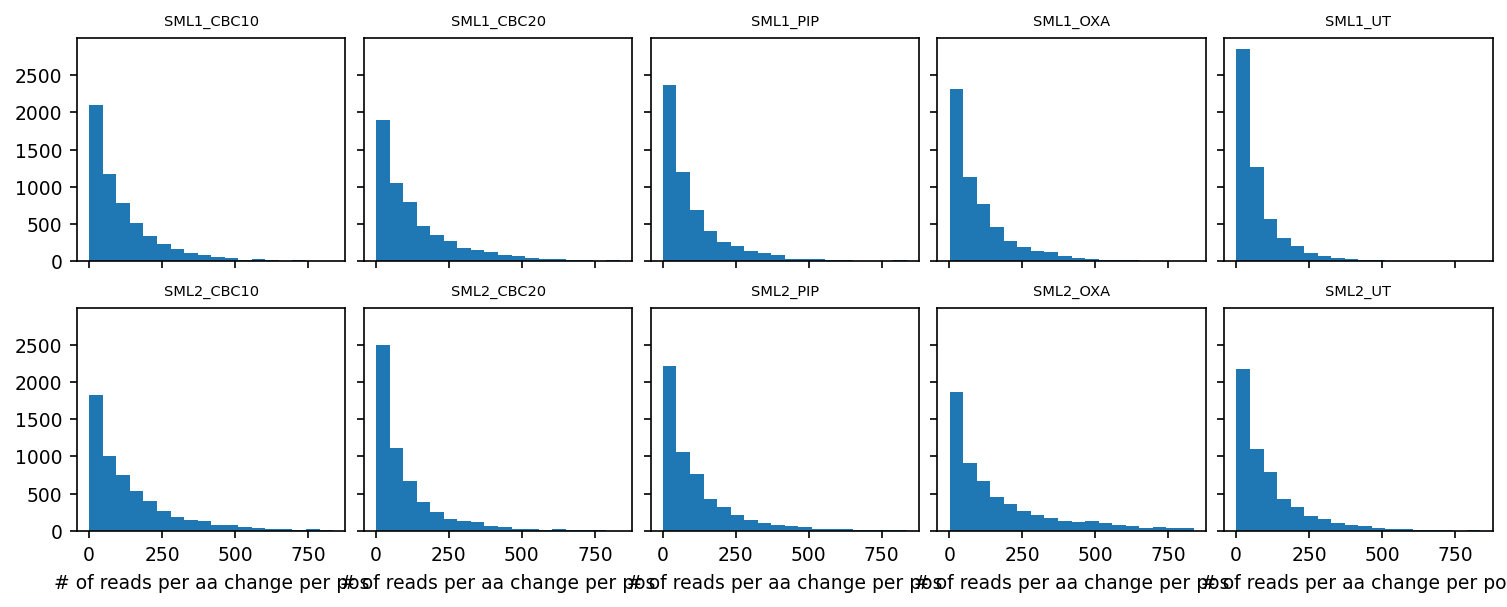

In [10]:
number_of_plots = len(REPLICAS)*len(DRUGS)+1
fig, axes = plt.subplots(len(REPLICAS),len(DRUGS)+1, figsize=((len(DRUGS)+1)*2,len(REPLICAS)*2),sharex=True, sharey=True,dpi=150);
plt.rc('font', size=5)

# find limits
all_reads = []
for replica in REPLICAS:
    for drug in DRUGS + ['UT']:
        sample = f"SML{replica}_{drug}"
        all_reads.extend(aa_dists[sample].values.flatten())
bins = np.linspace(np.nanpercentile(all_reads,0),np.nanpercentile(all_reads,99),19)
ax_count=0
for replica in REPLICAS:
    for drug in DRUGS + ['UT']:
        ax = axes.flat[ax_count]
        sample = f"SML{replica}_{drug}"
        reads = aa_dists[sample].values.flatten()
        ax.hist(reads, bins=bins)
        ax.set_xticks(np.arange(0,max(bins),250))
        if replica==REPLICAS[-1]:
            ax.set_xlabel('# of reads per aa change per pos')
        ax.set_title(f"{sample}", fontsize=7)
        ax_count+=1
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

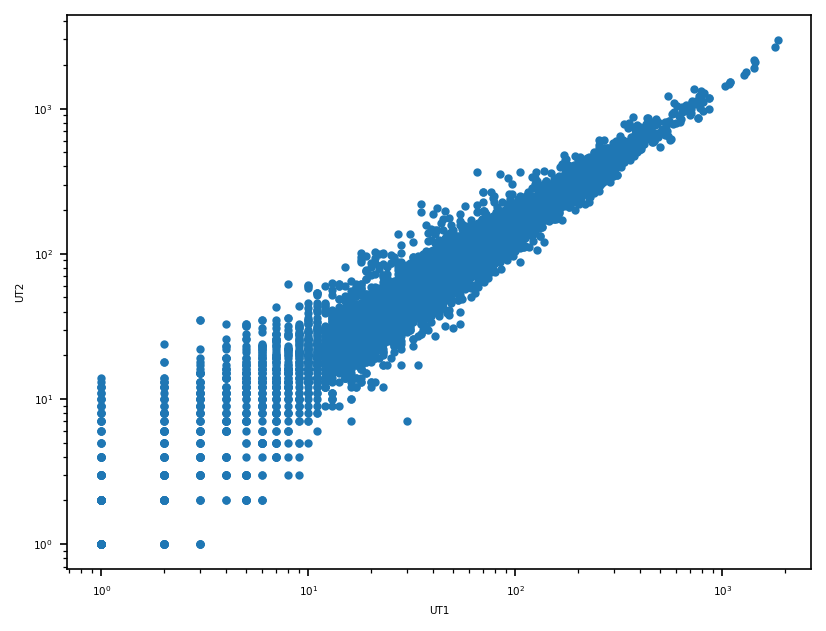

In [11]:
x = aa_dists['SML1_UT'].values.flatten()
y = aa_dists['SML2_UT'].values.flatten()
fig, ax = plt.subplots(1,1,dpi=150)
ax.scatter(x,y,marker='.')
ax.set(xlabel='UT1', ylabel='UT2')
ax.set_yscale('log')
ax.set_xscale('log')

#### Calculate the relative fitness of every amino acid change at every position

In [12]:
fitness={}
rel_fitness={}
rel_fitness_filt={}
read_noise_threshold = 20
for drug in DRUGS:
    for replica in REPLICAS:
        sample = f"SML{replica}_{drug}"
        fitness[sample] = np.log10(aa_dists[sample].replace(0,1)/read_counts.loc[sample, 'read_count']) - np.log10(aa_dists[f'SML{replica}_UT'].replace(0,1)/read_counts.loc[f'SML{replica}_UT','read_count'])
        fitness[sample].replace([np.inf, -np.inf], np.nan, inplace=True)
        rel_fitness[sample] = fitness[sample]-np.nanmean(fitness[sample].T['∅'])
        rel_fitness_filt[sample] = rel_fitness[sample].copy(deep=True)
        rel_fitness_filt[sample][ (aa_dists[sample]<read_noise_threshold) & (aa_dists[f'SML{replica}_UT']<read_noise_threshold) ] = np.nan
        rel_fitness_filt[sample].columns = rel_fitness_filt[sample].columns.astype(int) 

        print(sample, np.round(100*(1-sum(np.isnan(rel_fitness[sample].values.flatten()))/len(rel_fitness[sample].values.flatten())),1), "percent of all possible single amino changes covered with n>0.")
        print(sample, np.round(100*(1-sum(np.isnan(rel_fitness_filt[sample].values.flatten()))/len(rel_fitness_filt[sample].values.flatten())),1), f"percent of all possible single amino changes covered with n>{read_noise_threshold}.")

SML1_CBC10 49.8 percent of all possible single amino changes covered with n>0.
SML1_CBC10 43.1 percent of all possible single amino changes covered with n>20.
SML2_CBC10 50.2 percent of all possible single amino changes covered with n>0.
SML2_CBC10 45.0 percent of all possible single amino changes covered with n>20.
SML1_CBC20 49.7 percent of all possible single amino changes covered with n>0.
SML1_CBC20 44.0 percent of all possible single amino changes covered with n>20.
SML2_CBC20 49.9 percent of all possible single amino changes covered with n>0.
SML2_CBC20 42.8 percent of all possible single amino changes covered with n>20.
SML1_PIP 49.6 percent of all possible single amino changes covered with n>0.
SML1_PIP 41.2 percent of all possible single amino changes covered with n>20.
SML2_PIP 50.0 percent of all possible single amino changes covered with n>0.
SML2_PIP 43.7 percent of all possible single amino changes covered with n>20.
SML1_OXA 49.8 percent of all possible single amino cha

#### Relative fitness of at every position at every amino acid: raw data heatmap

In [64]:
import matplotlib.patches as patches

number_of_plots = len(REPLICAS)*(len(DRUGS))
fig, axes = plt.subplots(number_of_plots,1,figsize=(80,number_of_plots*9),dpi=150);
ax_count = 0
for drug in DRUGS:
    for replica in REPLICAS:
        sample = f"SML{replica}_{drug}"
        sns.heatmap(rel_fitness_filt[sample], cmap="coolwarm", vmin=-2, vmax=2, ax=axes[ax_count], cbar=False);
        axes[ax_count].set_title(f"Relative fitness {sample}", fontsize=36)
        for order, i in enumerate(fitness[sample].T.index):
            pos = int(i)-1
            ref_base = np.where(ref_aa_seq_full[pos] == fitness[sample].index)[0][0]
            axes[ax_count].add_patch(patches.Rectangle((order-1, ref_base), 1.0, 1.0, edgecolor='black', facecolor="white", lw=2))
        axes[ax_count].set_yticklabels(axes[ax_count].get_yticklabels(), fontsize=22)
        axes[ax_count].set_xticklabels(np.arange(1,len(rel_fitness[sample].columns)+1), fontsize=18)
        axes[ax_count].tick_params(axis='y', rotation=0)
        axes[ax_count].tick_params(axis='x', rotation=90)
        ax_count+=1
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.28)
fig.savefig(export_path / '02_Relative fitness heatmaps.png', dpi=300)

#### Relative fitness distributions of every sample in the library

NameError: name 'export_path' is not defined

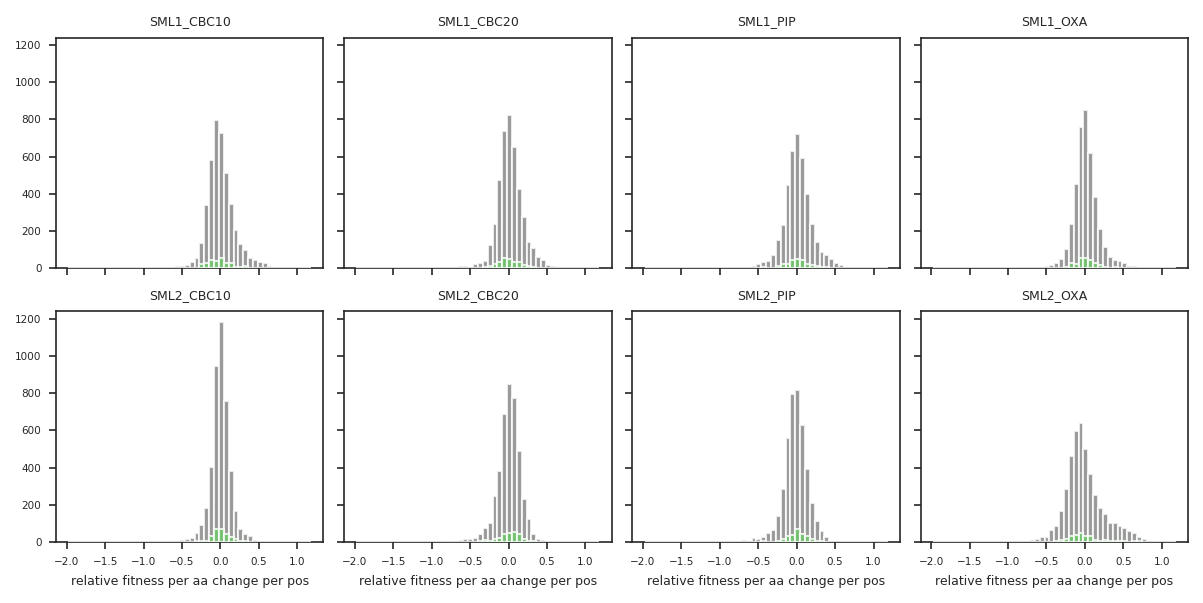

In [13]:
# set colormap for following plots
sns.set_style('ticks')
palette=sns.color_palette('muted')
red=palette[3]
blue=palette[0]
green=palette[2]

number_of_plots = len(REPLICAS)*len(DRUGS)
fig, axes = plt.subplots(len(REPLICAS),len(DRUGS), figsize=((len(DRUGS))*2,len(REPLICAS)*2),sharex=True, sharey=True,dpi=150);
plt.rc('font', size=6)

# find limits
all_reads = []
for replica in REPLICAS:
    for drug in DRUGS:
        sample = f"SML{replica}_{drug}"
        df = rel_fitness_filt[sample]
        all_reads.extend(df.drop(['*','∅']).values.flatten())
bins = np.linspace(np.nanpercentile(all_reads,0),np.nanpercentile(all_reads,100),51)
ax_count=0
for replica in REPLICAS:
    for drug in DRUGS:
        ax = axes.flat[ax_count]
        sample = f"SML{replica}_{drug}"
        df = rel_fitness_filt[sample]
        # plot all fitness values in gray
        all_fit = df.drop(['*','∅']).values.flatten()
        ax.hist(all_fit, bins=bins, color='gray', alpha=0.8)
        # plot synonomous mutations in green
        syn = df.loc['∅',:].values
        ax.hist(syn, bins=bins, color=green, alpha=0.8, zorder=10)
        # # plot missense mutations in red
        # syn = rel_fitness[sample].loc['*',:].values
        # ax.hist(syn, bins=bins, color=red, alpha=0.8, zorder=100)
        #ax.set_ylabel('# of reads per aa change per pos')
        if replica == REPLICAS[-1]:
            ax.set_xlabel('relative fitness per aa change per pos', fontsize=6)
        ax.set_title(f"{sample}", fontsize=6)
        ax_count+=1
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.savefig(export_path / '03_Relative fitness histograms.png', dpi=600)

#### Find resistance/sensitivity conferring mutations that are significantly enriched compared to synonymous wild-type mutations

CBC10 0.0002380515938843845 0.21254160486271362 0.0037926919887373406 0.13420682650789595
CBC20 0.010558505874571663 0.20168740532715745 0.0005603137302368675 0.16934706457009113
PIP 0.008784291762801084 0.204706090103422 -0.002582223729778012 0.1711071798398923
OXA 0.010144664067534151 0.1880783395328205 0.015759199056068027 0.2572174401702157


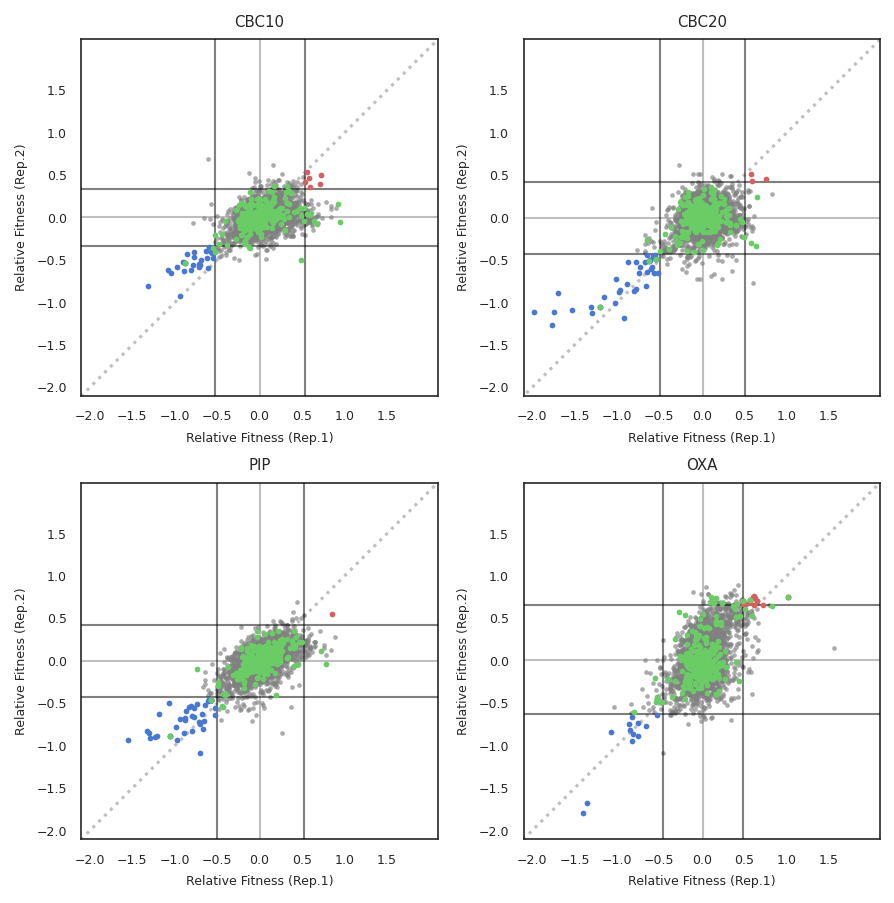

In [27]:
def scatter_rel_fitness(x, y, drug, ax, sigma=3):
    xl = x.reset_index().melt(id_vars=['index']).rename(columns={'index':'aa','variable':'pos'}).set_index(['aa','pos'])
    yl = y.reset_index().melt(id_vars=['index']).rename(columns={'index':'aa','variable':'pos'}).set_index(['aa','pos'])
    #ax.axis('equal')
    synonymous = xl.index.get_level_values('aa')=='∅'
    xmean = np.nanmean(xl.loc[synonymous,'value'])
    xstd = np.std(xl.loc[synonymous,'value'])
    ymean = np.nanmean(yl.loc[synonymous,'value'])
    ystd = np.std(yl.loc[synonymous,'value'])
    print(drug,xmean,xstd,ymean,ystd)
    # significance test
    # merge two dataframes element-wise for significance test
    xy = pd.concat([x,y]).groupby(level=0,axis=0).agg(list)
    def is_sign_resistant(row):
        if np.isnan(row).any():
            return False
        x, y = row
        return (x>(xmean+sigma*xstd)) and (y>(ymean+sigma*ystd))
    def is_sign_sensitive(row):
        if np.isnan(row).any():
            return False
        x, y = row
        return (x<(xmean-sigma*xstd)) and (y<(ymean-sigma*ystd))
    sign_resistant = xy.applymap(is_sign_resistant)
    sign_sensitive = xy.applymap(is_sign_sensitive)
    # axis lines and limits
    ax.plot([-4,4],[-4,4],':', color='gray', alpha=0.5, zorder=0)
    ax.plot([xmean,xmean],[-4,4],'-', color='gray', alpha=0.5, lw=1,zorder=0)
    ax.plot([-4,4],[ymean,ymean],'-', color='gray', alpha=0.5, lw=1,zorder=0)
    for s in [sigma]:
        ax.plot([-4,4],[ymean+s*ystd,ymean+s*ystd],'-', color='black', alpha=0.5, lw=1,zorder=100)
        ax.plot([-4,4],[ymean-s*ystd,ymean-s*ystd],'-', color='black', alpha=0.5, lw=1,zorder=100)
    for s in [sigma]:
        ax.plot([xmean+s*xstd,xmean+s*xstd],[-4,4],'-', color='black', alpha=0.5, lw=1,zorder=100)
        ax.plot([xmean-s*xstd,xmean-s*xstd],[-4,4],'-', color='black', alpha=0.5, lw=1,zorder=100)
    
    # plot all mutations: inconclusive, significant resistance, significant sensitive, and neutral wild-type
    ax.scatter(xl, yl, color='gray', lw=0, alpha=0.66, s=5, zorder=2)
    ax.scatter(x[sign_resistant], y[sign_resistant], color=red, s=3, zorder=100)
    ax.scatter(x[sign_sensitive], y[sign_sensitive], color=blue, s=3, zorder=100)
    ax.scatter(xl[synonymous], yl[synonymous], color=green, s=3, zorder=101)

    ax.set(xlim=(-2.1,2.1), ylim=(-2.1,2.1))
    ax.set(xticks=np.arange(-2,2,0.5), yticks=np.arange(-2,2,0.5))
    ax.set(title=drug,xlabel=f"Relative Fitness (Rep.1)", ylabel=f"Relative Fitness (Rep.2)")
    ax.set_anchor('NW')

    return sign_resistant, sign_sensitive

sign_resistance_index=dict()
sign_sensitivity_index=dict()
sign_resistance_mutations=dict()
sign_sensitivity_mutations=dict()
fig, axes = plt.subplots(2, 2, figsize=(6,6), dpi=150, subplot_kw=dict(adjustable='box', aspect='equal'))
for outerind, ax in enumerate(axes.flatten()):
    drug = DRUGS[outerind]
    rep1 = rel_fitness_filt[f"SML1_{drug}"]
    rep2 = rel_fitness_filt[f"SML2_{drug}"]
    sign_resistant, sign_sensitive = scatter_rel_fitness(rep1, rep2, drug, ax, sigma=2.5)
    
    # save significant mutations
    sign_resistance_index[drug] = sign_resistant
    sign_sensitivity_index[drug] = sign_sensitive
    sign_resistance_mutations[drug] = pd.concat([rel_fitness_filt[f"SML1_{drug}"][sign_resistant].stack(), rel_fitness_filt[f"SML2_{drug}"][sign_resistant].stack()], axis=1)
    sign_sensitivity_mutations[drug] = pd.concat([rel_fitness_filt[f"SML1_{drug}"][sign_sensitive].stack(), rel_fitness_filt[f"SML2_{drug}"][sign_sensitive].stack()], axis=1)
fig.tight_layout()
fig.savefig(export_path / f'04_Significance test sigma 2.5.png', dpi=600)

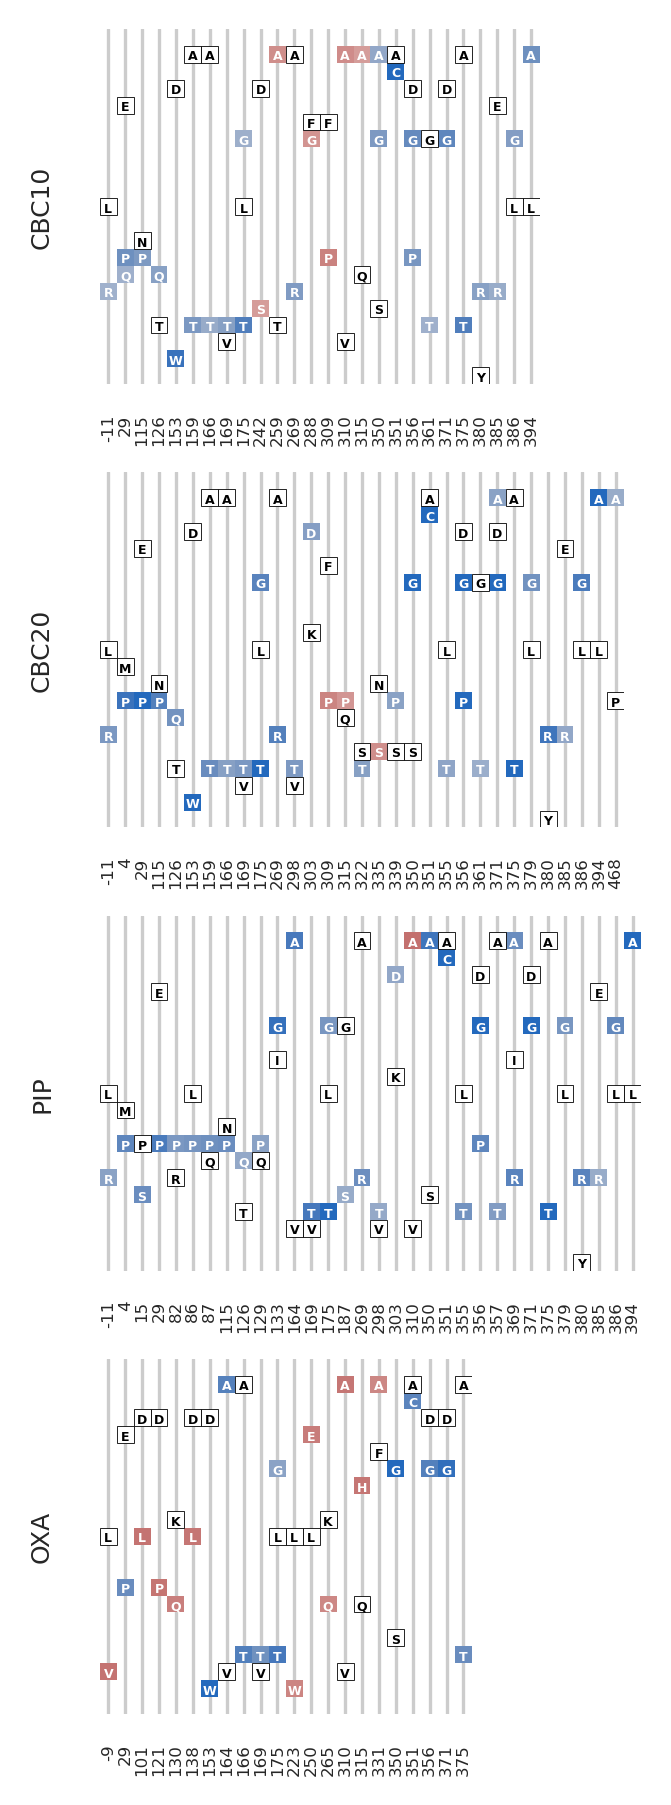

In [28]:
# let there be shish kabob plots
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
sns.set_style('white')

def shish_kabob_plot(rel_fitness_filt, drug, ax, cbar=False):
    df = rel_fitness_filt
    df = pd.concat([df[f"SML1_{drug}"], df[f"SML2_{drug}"]]).groupby(level=0,axis=0).agg(lambda x: np.mean(x))#x[np.argmax(np.abs(x))])
    combined_index = sign_resistance_index[drug].drop('*') | sign_sensitivity_index[drug].drop('*')
    sign_positions = (combined_index.sum()>0)
    sign_only_syn_pos = (combined_index.sum()==2) & (combined_index.loc['∅',:])
    sign_positions = (sign_positions & ~sign_only_syn_pos)
    sign_positions = sign_positions[sign_positions].index
    df_masked = df.copy(deep=True)
    df_masked[~(sign_resistance_index[drug] | sign_sensitivity_index[drug])] = np.nan
    df_masked = df_masked.drop('∅')
    sns.heatmap(df_masked.loc[:,sign_positions], cmap="vlag", vmin=-1, vmax=1, ax=ax, cbar=cbar);
    ax.set_aspect('equal')
    ax.xaxis.grid('on')
    ax.set_ylabel(f"{drug}", fontsize=fontsize+2)
    for order, i in enumerate(df_masked.loc[:,sign_positions].T.index):
        pos = int(i)
        ref_base = np.where(ref_aa_seq_full[pos] == df_masked.index)[0][0]
        ax.add_patch(patches.Rectangle((order,ref_base), 1.0, 1.0, edgecolor='black', facecolor="white", lw=0.2))
        ax.text(order+.5, ref_base+.8, ref_aa_seq_full[pos], fontsize=fontsize-1, fontweight='bold',
                color='black', ha='center', zorder=100)
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels([], fontsize=fontsize)
    ax.set_xticks(np.arange(len(sign_positions))+0.5)
    ax.set_xticklabels(np.array(sign_positions)-21, ha='center', fontsize=fontsize)
    ax.tick_params(axis='y', rotation=0)
    ax.tick_params(axis='x', rotation=90)
    for posorder, pos in enumerate(sign_positions):
        for order, i in enumerate(df_masked.index):
            if not np.isnan(df_masked.loc[i,pos]):
                ax.text(posorder+.5, order+.8, str(i), fontsize=fontsize-1, fontweight='bold', color='white', ha='center')
    ax.set_anchor('NW')

fontsize = 4
number_of_plots = (len(DRUGS))
#fig, axes = plt.subplots(number_of_plots,2,figsize=(20,number_of_plots*2),dpi=150);

fig, axes = plt.subplots(number_of_plots, 1, figsize=(10,6),dpi=300)
for ax_count, drug in enumerate(DRUGS):
    ax = axes.flat[ax_count]
    shish_kabob_plot(rel_fitness_filt, drug, ax)
plt.tight_layout()
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.28)
fig.savefig(export_path / f'05_Shish-kabop plot with significance tests.png', dpi=600)

In [68]:
all_sign = []
for drug in DRUGS:
    df = rel_fitness_filt
    df = pd.concat([df[f"SML1_{drug}"], df[f"SML2_{drug}"]]).groupby(level=0,axis=0).agg(lambda x: np.mean(x))#x[np.argmax(np.abs(x))])
    combined_index = sign_resistance_index[drug].drop('*') | sign_sensitivity_index[drug].drop('*')
    sign_positions = (combined_index.sum()>0)
    sign_only_syn_pos = (combined_index.sum()==2) & (combined_index.loc['∅',:])
    sign_positions = (sign_positions & ~sign_only_syn_pos)
    sign_positions = sign_positions[sign_positions].index
    all_sign.append(sign_positions)

In [73]:
union = sorted(list(set([item for l in all_sign for item in l])))
print(union)

[10, 12, 25, 36, 50, 103, 107, 108, 122, 136, 142, 147, 150, 151, 154, 159, 174, 180, 185, 187, 190, 196, 208, 244, 263, 271, 280, 286, 290, 309, 319, 324, 330, 331, 336, 343, 352, 356, 360, 371, 372, 376, 377, 378, 382, 390, 392, 396, 400, 401, 406, 407, 415, 489]


[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]


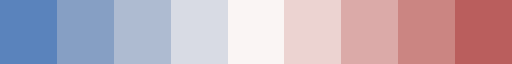

In [181]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

# Create a list of points where the colors change
bounds = np.linspace(-1, 1, 9)

# Create a discrete colormap
cmap = ListedColormap(sns.color_palette("vlag", n_colors=9))

print(bounds)
cmap

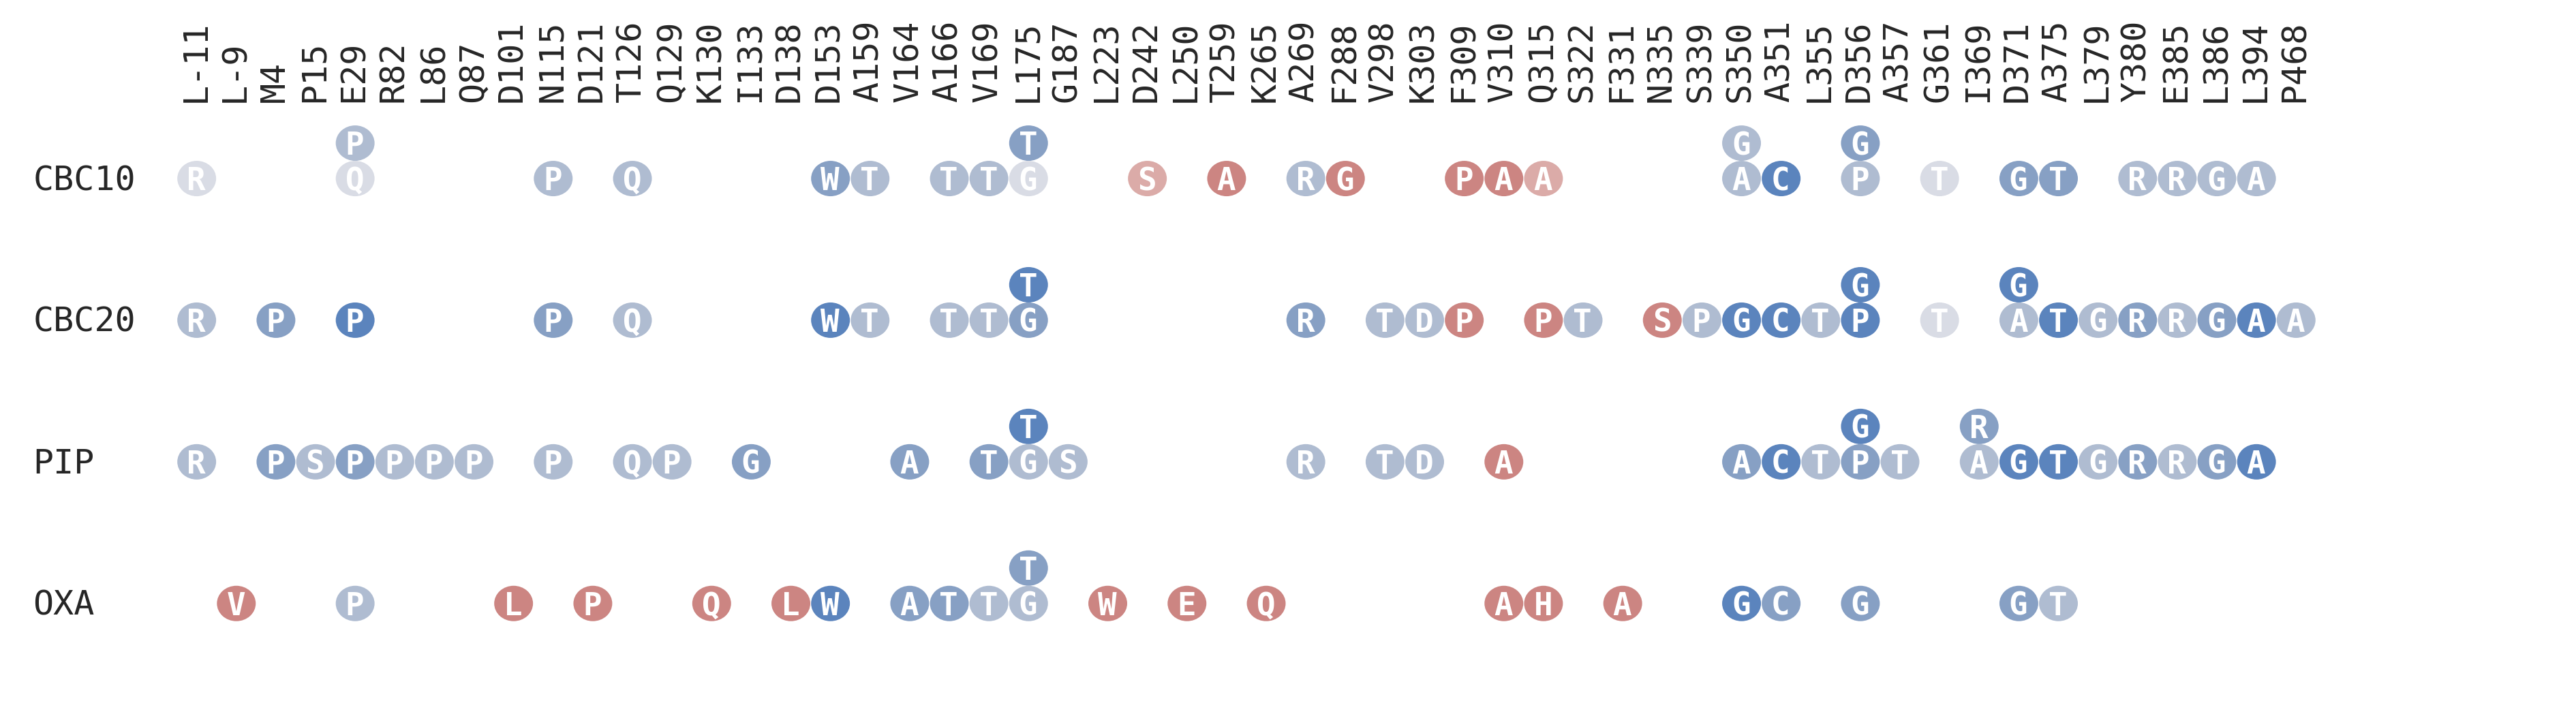

In [260]:

params = {'x_length_inches': 16,
         'y_length_inches': 4,
         'x_start_offset': 2,
         'x_end_offset': 5,
         'letterbox_size_x': 0.5,
         'letterbox_size_y': 0.5,
         'x_col_width': 0.5,
         'y_row_height': 0.9,
         'left_margin': 0.01,
         'bottom_margin': 0.05,
         'dpi': 300}
# create the canvas
f, ax = plt.subplots(1,1,figsize=(params['x_length_inches'], params['y_length_inches']), dpi=params['dpi'])
# Remove all the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# store x-pos of every pos here
xpos = dict()
# top x-axis with reference amino acids
for aa_pos in np.arange(0,len(union)):
    x = params['x_start_offset']+aa_pos*params['x_col_width']
    y = params['y_length_inches']*.95
    label = ref_aa_seq[union[aa_pos]]+str(union[aa_pos]-21)
    # plot amino acid position labels for the x-axis
    ax.text(x, y, label, rotation=90, fontdict={'fontsize':12,'family':'monospace'})
    # store xpos
    xpos[union[aa_pos]] = x
    # label the amino acids by letter from the reference protein sequence
    #ax.text(params['x_start_offset']+x, params['y_length_inches']*.88, ref_aa_seq[sign_positions[x]], ha='center', va='center', fontsize=12)
    # # add rectangular frames for the reference letters
    # sx, sy = params['letterbox_size_x'], params['letterbox_size_y'] 
    # ax.add_patch(patches.Rectangle((params['x_start_offset']+x-sx/2, 0.88-sy/2), sx, sy,
    #                                edgecolor='black', facecolor="white", lw=1))

# store ypos of every sample here
ypos = dict()
# left y-axis with sample names
for row, drug in enumerate(DRUGS):
    # calculate sample name position
    left_margin = params['x_length_inches']*params['left_margin']
    bottom_margin = params['y_length_inches']*params['bottom_margin']
    row_y_pos = bottom_margin+len(DRUGS)-1-row*params['y_row_height']
    # write sample name
    ax.text(left_margin, row_y_pos, drug,
            fontdict={'fontsize':12,'family':'monospace'})
    # store its row position
    ypos[drug] = row_y_pos

# place significant mutations
for drug in DRUGS:
    mut = []
    # collect sensitivity mutations
    for ix, row in sign_sensitivity_mutations[drug].iterrows():
        if ix[1] in xpos:
            mut.append({'mut_pos': ix[1], 'mut_aa':ix[0], 'logFC':np.mean(row.values)})
    # collect resistance mutations
    for ix, row in sign_resistance_mutations[drug].iterrows():
        if ix[1] in xpos:
            mut.append({'mut_pos': ix[1], 'mut_aa':ix[0], 'logFC':np.mean(row.values)})
    mut = pd.DataFrame(mut).sort_values(by='logFC').reset_index()
    mut_pos = mut.groupby(['mut_pos'])[['mut_aa','logFC']].agg(list)
    
    for ix, row in mut_pos.iterrows():
        if ix in xpos:
            y_shift = (params['y_row_height']/4)
            y_base = ypos[drug]+((len(row['mut_aa'])-1)*y_shift)
            for letter in range(len(row['mut_aa'])):
                x = xpos[ix]
                y = y_base-letter*y_shift
                ax.text(x+0.1, y, row['mut_aa'][letter], fontdict={'fontsize':11,'family':'monospace','color':'white', 'fontweight':'bold'})
                # add rectangular frames for the reference letters
                sx, sy = params['x_col_width']-0.01, y_shift
                # ax.add_patch(patches.Rectangle((x, y-0.05), sx, sy, edgecolor='none', lw=1,
                #                               facecolor=cmap.colors[np.searchsorted(bounds,row['logFC'][letter])]))
                ax.add_patch(patches.Ellipse((x-0.02+sx/2, y-0.04+sy/2), sx, sy, edgecolor='none', lw=1,
                                              facecolor=cmap.colors[np.searchsorted(bounds,row['logFC'][letter])]))
ax.set(xticklabels=[], yticklabels=[])
ax.set_ylim([0,4])
ax.set_xlim([0,len(union)*params['x_col_width']+params['x_end_offset']])
plt.savefig(export_path / f"07_abacus plot.png", dpi=600)

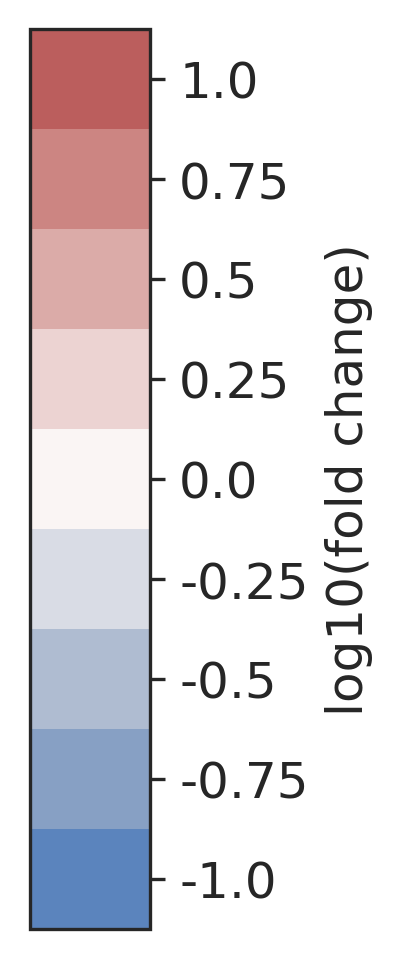

In [257]:
plt.figure(figsize=(.5, 5), dpi=300)
img = plt.imshow(np.array([[0,1]]), cmap=cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="vertical", cax=cax)
cbar.set_ticks(np.arange(0,1,1/len(bounds))+0.5/len(bounds))
cbar.set_ticklabels(bounds, fontsize=12)#["%.2f"%b for b in 10**bounds])
cbar.set_label('log10(fold change)',fontsize=12)
plt.savefig(export_path / f"07_abacus_plot_colorbar.png", dpi=600, bbox_inches='tight')

In [226]:
bounds

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ])

In [174]:
cmap.colors[0]

(0.35551826, 0.51744353, 0.73994642)

In [157]:
len(union)

54

In [140]:
sign_sensitivity_mutations['CBC20']

0         1
C 372 -1.979565 -1.110380
T 180 -0.661966 -0.807267
  187 -0.671707 -0.523966
  190 -0.778471 -0.524987
  196 -1.762498 -1.266762
  319 -0.647590 -0.641156
  343 -0.595169 -0.601802
  376 -0.610067 -0.502477
  382 -0.555201 -0.441191
  396 -1.742259 -1.110758
  398 -0.621960 -0.511044
Q 147 -0.865041 -0.525366
R 10  -0.727433 -0.584908
  290 -0.797548 -0.865973
  401 -0.960829 -0.854010
  406 -0.650793 -0.441041
D 324 -0.558009 -0.656832
G 196 -0.779596 -0.845216
  371 -0.916774 -1.182931
  377 -1.291352 -1.119142
  392 -1.531799 -1.086021
  400 -0.740299 -0.656051
  407 -1.009065 -0.728086
A 55  -0.545765 -0.485141
  392 -0.582177 -0.578788
  408 -1.205226 -1.056149
  415 -1.694526 -0.888090
  489 -0.570781 -0.449686
W 174 -1.301350 -1.057992
P 25  -0.974766 -0.870319
  50  -1.027355 -1.006353
  136 -0.881434 -0.787550
  360 -0.512858 -0.655456
  377 -1.154135 -0.934419
* 200 -0.611588 -0.496631
∅ 55  -0.545765 -0.485141
  398 -0.621960 -0.511044
  408 -1.205226 -1.056149

#### Export all relative fitness measurements

In [68]:
all_rel_fit = []
for drug in DRUGS:
    df = rel_fitness
    for i in df[f"SML1_{drug}"].index:
        for pos in df[f"SML1_{drug}"].columns:
            all_rel_fit.append({
                'aa_pos': int(pos)-21,
                'ref_aa': ref_aa_seq_full[int(pos)],
                'mut_aa': i,
                'drug': drug,
                'rel_fitness_1': df[f"SML1_{drug}"].loc[i,pos],
                'rel_fitness_2': df[f"SML2_{drug}"].loc[i,pos],
                'rel_fitness_mean': np.nanmean([df[f"SML1_{drug}"].loc[i,pos], df[f"SML2_{drug}"].loc[i,pos]]),
                'significant': sign_resistance_index[drug].loc[i,int(pos)] or sign_sensitivity_index[drug].loc[i,int(pos)]
            })
all_rel_fit = pd.DataFrame(all_rel_fit)
all_rel_fit.to_csv(PROJECT_PATH / "dump" / EXP_ID / '01_All relative fitness table.csv', index=False)
all_rel_fit

,aa_pos,ref_aa,mut_aa,drug,rel_fitness_1,rel_fitness_2,rel_fitness_mean,significant
0,-21,M,C,CBC10,-0.062934,0.098589,0.017827,False
1,-20,K,C,CBC10,NaN,NaN,NaN,False
2,-19,K,C,CBC10,-0.272685,0.097814,-0.087435,False
3,-18,L,C,CBC10,0.007156,-0.067554,-0.030199,False
4,-17,L,C,CBC10,0.125255,-0.145486,-0.010115,False
...,...,...,...,...,...,...,...,...
43555,469,F,∅,OXA,-0.058509,0.058914,0.000202,False
43556,470,R,∅,OXA,-0.076238,-0.176167,-0.126202,False
43557,471,N,∅,OXA,-0.191484,0.081398,-0.055043,False
43558,472,*,∅,OXA,-0.064338,0.251344,0.093503,False


#### Relative fitness of every mutation in every drug pair

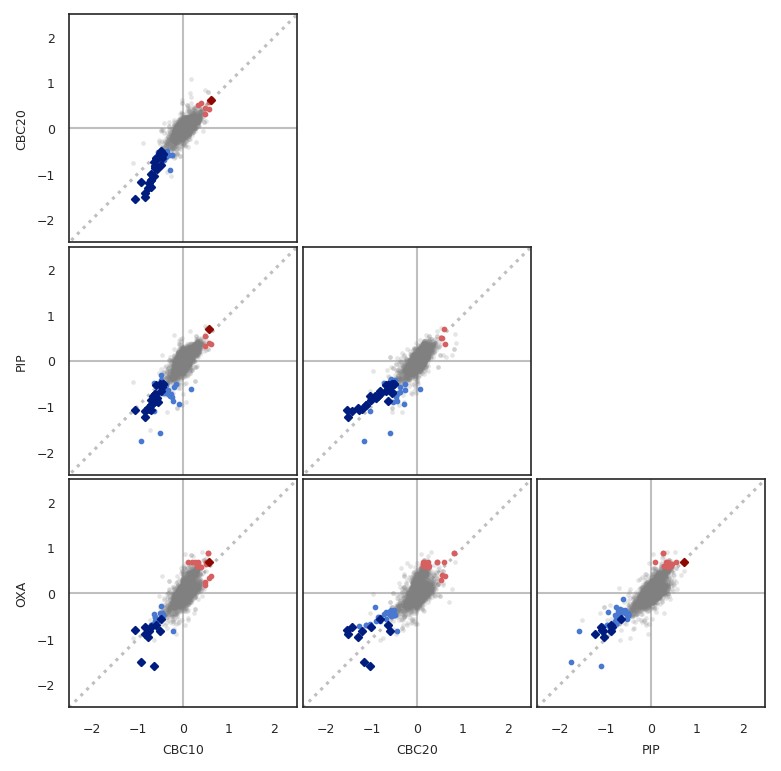

In [69]:
red=palette[3]
blue=palette[0]
green=palette[2]
dred=sns.color_palette("dark")[3]
dblue=sns.color_palette("dark")[0]
dgreen=sns.color_palette("dark")[2]

def drug_pair(df, drug1, drug2, ax):
    # merge two replica dataframes element-wise for significance test
    drug1_xy = pd.concat([df[f"SML1_{drug1}"],df[f"SML2_{drug1}"]]).groupby(level=0,axis=0).agg(np.mean)#lambda x: x[np.argmax(np.abs(x))])
    drug2_xy = pd.concat([df[f"SML1_{drug2}"],df[f"SML2_{drug2}"]]).groupby(level=0,axis=0).agg(np.mean)#lambda x: x[np.argmax(np.abs(x))])
    # build numpy matrix for gaussian model fit and plotting
    X = np.column_stack((drug1_xy.values.flatten(), drug2_xy.values.flatten()))
    # filter out if any of the drugs has NaN value
    X = X[~np.isnan(X).any(axis=1)]
    # select synonomous mutations only
    x_syn = drug1_xy.T['∅']
    y_syn = drug2_xy.T['∅']
    # build numpy matrix for gaussian model fit and plotting
    X_syn = np.column_stack((x_syn.values.flatten(), y_syn.values.flatten()))
    # filter out if any of the replicas has NaN value
    X_syn = X_syn[~np.isnan(X_syn).any(axis=1)]
    # plot all mutations: inconclusive, significant resistance, significant sensitive, and neutral wild-type
    ax.scatter(X[:, 0], X[:, 1], color='gray', lw=0, alpha=0.2, s=5, zorder=2)
    #ax.scatter(X_syn[:, 0], X_syn[:, 1], color=green, s=3, zorder=10)
    ax.scatter(drug1_xy[sign_resistance_index[drug1]], drug2_xy[sign_resistance_index[drug1]], color=red, s=3, zorder=100)
    ax.scatter(drug1_xy[sign_resistance_index[drug2]], drug2_xy[sign_resistance_index[drug2]], color=red, s=3, zorder=100)
    ax.scatter(drug1_xy[sign_resistance_index[drug1] & sign_resistance_index[drug2]], drug2_xy[sign_resistance_index[drug1] & sign_resistance_index[drug2]], color=dred, marker='D', s=6, zorder=101)
    ax.scatter(drug1_xy[sign_sensitivity_index[drug1]], drug2_xy[sign_sensitivity_index[drug1]], color=blue, s=3, zorder=100)
    ax.scatter(drug1_xy[sign_sensitivity_index[drug2]], drug2_xy[sign_sensitivity_index[drug2]], color=blue, s=3, zorder=100)
    ax.scatter(drug1_xy[sign_sensitivity_index[drug1] & sign_sensitivity_index[drug2]], drug2_xy[sign_sensitivity_index[drug1] & sign_sensitivity_index[drug2]], color=dblue, marker='D', s=6, zorder=101)
    #ax.axis('equal')
    # axis lines and limits
    ax.plot([-4,4],[-4,4],':', color='gray', alpha=0.5, zorder=0)
    ax.plot([0,0],[-4,4],'-', color='gray', alpha=0.5, lw=1,zorder=0)
    ax.plot([-4,4],[0,0],'-', color='gray', alpha=0.5, lw=1,zorder=0)
    ax.set(xlim=(-2.5,2.5), ylim=(-2.5,2.5))
    ax.set_anchor('NW')

fig, axes = plt.subplots(len(DRUGS)-1, len(DRUGS)-1, sharex=True, sharey=True,
    figsize=(6,6), dpi=150, subplot_kw=dict(adjustable='box', aspect='equal'))
for ax_row, drug1i in enumerate(DRUGS):
    for ax_col, drug2i in enumerate(DRUGS):
        if ax_row>ax_col:
            ax = axes[ax_row-1,ax_col]
            drug_pair(rel_fitness_filt, drug2i, drug1i,  ax)
            if ax_col==0:
                ax.set_ylabel(drug1i)
            if ax_row==len(DRUGS)-1:
                ax.set_xlabel(drug2i)
        elif ax_row>0 and ax_col<(len(DRUGS)-1):
            axes[ax_row-1,ax_col].axis('off')
#plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.02)
fig.savefig(export_path / f'06_Drug pairs significance tests.png', dpi=300)

#### Export significant mutations

In [72]:
from pandas import ExcelWriter
from IPython.display import display_html
def display_side_by_side(args):
    html_str=''
    for df in args:
        df_styler = df.style.set_table_attributes("style='vertical-align:top;display:inline'")
        html_str += df_styler._repr_html_()
        html_str += "\xa0\xa0\xa0\xa0\xa0\xa0"
    display_html(html_str, raw=True)

def custom_table(input_table):
    sign_muts=[]
    for drug in DRUGS:
        df = input_table[drug].rename(columns={0:f"SML1_{drug}", 1:f"SML2_{drug}"})
        df = df.reset_index().rename(columns={'level_0':'mutated_aa', 'level_1':'residue'})
        df = df.set_index('residue')
        df = df.sort_index()
        df.index.name='residue'
        df.insert(loc=0, column='ref_aa', value=[ref_aa_seq_full[i] for i in df.index])
        # PDB residue id has -21 offset from default amplicon coordinates 
        # TolC protein
        df.index = [int(i)-21 for i in df.index]
        sign_muts.append(df)
    return sign_muts

print("Significant resistance conferring mutations:")
with ExcelWriter(PROJECT_PATH / "dump" / EXP_ID / "02_Significant resistance mutations.xlsx") as writer:
    for table in custom_table(sign_resistance_mutations):
        table.to_excel(writer,table.columns[-1][:-1])
display_side_by_side(custom_table(sign_resistance_mutations))

Significant resistance conferring mutations:


,ref_aa,mutated_aa,SML1_CBC10,SML2_CBC10
242,D,S,0.591911,0.364082
259,T,A,0.561276,0.540371
288,F,G,0.581187,0.464237
309,F,P,0.723420,0.499214
310,V,A,0.711521,0.398844
315,Q,A,0.531603,0.417888
,ref_aa,mutated_aa,SML1_CBC20,SML2_CBC20
309,F,P,0.759348,0.457551
315,Q,P,0.593915,0.426816
335,N,S,0.580890,0.514952


In [73]:
print("Significant sensitivity conferring mutations:")
with ExcelWriter(PROJECT_PATH / "dump" / EXP_ID / "03_Significant sensitivity mutations.xlsx") as writer:
    for table in custom_table(sign_sensitivity_mutations):
        table.to_excel(writer,table.columns[-1][:-1])
display_side_by_side(custom_table(sign_sensitivity_mutations))

Significant sensitivity conferring mutations:


,ref_aa,mutated_aa,SML1_CBC10,SML2_CBC10
-11,L,R,-0.597310,-0.340474
29,E,P,-0.810658,-0.614254
29,E,Q,-0.552352,-0.413483
115,N,P,-0.706233,-0.560138
126,T,Q,-0.691977,-0.494168
153,D,W,-0.941691,-0.925667
159,A,T,-0.719843,-0.579967
166,A,T,-0.550930,-0.480582
169,V,T,-0.603337,-0.595082
175,L,T,-1.042688,-0.647199
